In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

    
    
# REPLACE <user>:<personal_token> with your CERN user name and personal access token you created in Gitlab.
# Please follow https://docs.gitlab.com/ee/user/profile/personal_access_tokens.html, under "Create a Personal Access Token"
# Don't forget to select the 'read_repository' scope when creating the token in Gitlab.

!git clone https://<user>:<personal_token>@gitlab.cern.ch/taul1ml/preprocessing.git
!pip install --upgrade tqdm

/bin/bash: line 1: user: No such file or directory
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 KB 704.9 kB/s eta 0:00:001m517.6 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

#from sklearn.ensemble import GradientBoostingClassifier

#from sklearn.model_selection import train_test_split
#from sklearn import metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import classification_report, roc_auc_score

from preprocessing.helpers import read_all_data, train_test_split, TurnOnCurveHolder

/tmp/ipykernel_111959/2431715093.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BKG["run3"][BKG["Jfex_iso"] > 0.4] = 0


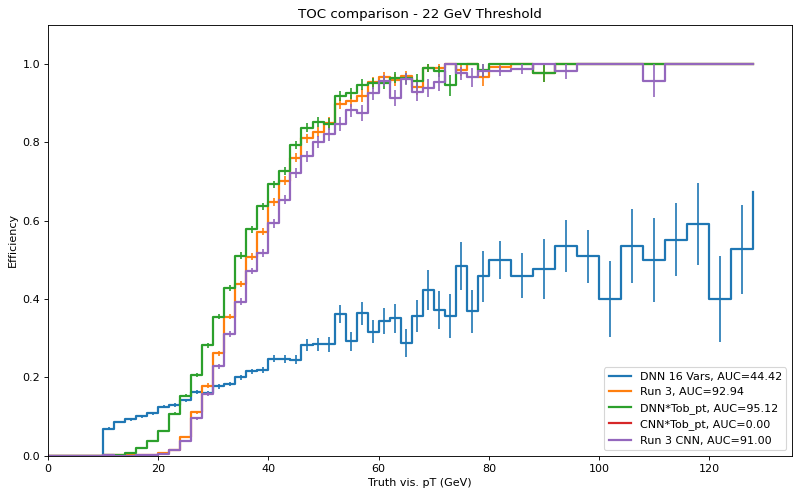

In [8]:
toc_holder = TurnOnCurveHolder()

CSVname = "/home/tlv/Downloads/DNN_Ratios_Only.csv" ### CSV with scores
Thresh = 22 ### The threshold in GeV for the Run3 algorithm.
test_df = pd.read_csv(CSVname)
test_df["truth_pt"]*=1000 ### set truth pt to GeV
test_df["run3"][test_df["signal"] == 0] *= 1000 ### change BKG to MeV. Signal already in MeV.
### Do not touch
BKG = test_df[test_df["signal"] == 0]
#BKG["run3"][BKG["Jfex_iso"] > 0.4] = 0
BKG = BKG.groupby("event_num").max("run3").reset_index()
fakerate = BKG[BKG["run3"] > 1000*Thresh].shape[0] ### Calculate fake rate allowed.


test_df["model_score"][test_df["tob_pt"] < 10000] = 0
test_df['tob_pt'][test_df['Jfex_iso'] > 900] = 0 ### set to 0 the score to all non-truth matched 
test_df['model_score'][test_df['Jfex_iso'] > 900] = 0

toc_holder.add_toc_manual_fake_rate(test_df,fakerate, "DNN 16 Vars")


### Do not touch 


test_df["model_score"] = test_df["run3"]


toc_holder.add_toc_manual_fake_rate(test_df,fakerate, "Run 3")


test_df = pd.read_csv(CSVname)
test_df["truth_pt"]*=1000
test_df["run3"][test_df["signal"] == 0] *= 1000


test_df["model_score"][test_df["tob_pt"] < 10000] = 0
test_df['tob_pt'][test_df['Jfex_iso'] > 900] = 0
test_df['model_score'][test_df['Jfex_iso'] > 900] = 0

### Up to here
test_df['model_score']+= 0.05*test_df['tob_pt']

toc_holder.add_toc_manual_fake_rate(test_df,fakerate, "DNN*Tob_pt")




toc_holder.plot(title="TOC comparison - "+str(Thresh)+" GeV Threshold")

